In [1]:
!pip install openai==1.14.2

# Import

In [3]:
import io
import re
import os
import json
import base64
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from openai import OpenAI

warnings.simplefilter('ignore')

# Constant

In [4]:
# Env variables
os.environ["OPEN_API_KEY"] = "<OPEN-API-KEY>"

# File Paths
CLEANED_DATA_PATH = '/kaggle/input/rta-dubai/sample_clean_application_data_2.xlsx'
UNCLEANED_DATA_PATH = '/kaggle/input/rta-dubai/sample_unclean_application_data_v2.xlsx'
METADATA_PATH = '/kaggle/input/rta-dubai/Application dataset.json'

# Chat-GPT Constants
TEMP = 1.0
TOP_P = 1.0
MAX_TOKENS = 500
FREQ_PENALTY = 0.5
PRES_PENALTY = 0.5
OPEN_AI_CLIENT = OpenAI(api_key=os.getenv("OPEN_API_KEY") ,organization='org-2EugvoZZidKLd5DkFH3dGTIA')

# Models

In [5]:
class MetaData:
    def __init__(self, data):
        self.__dict__ = data

# Helper Function

In [6]:
def load_json_and_map_to_class(json_path):
    try:
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
            return MetaData(data)
    except json.JSONDecodeError:
        print(f"Error: Unable to decode JSON from file '{file_path}'. File may be empty or not in valid JSON format.")
        return None


def extract_column_attributes_for_column_name_mapping(metadata_json):
    columns_meta_data = []
    for column in metadata_json.attributes:
        columns_meta_data.append({
            "name": column['attribute_name'],
            "description": column['description'], 
            "synonyms": column['synonyms']
        })
    return json.dumps(columns_meta_data)


def convert_dataframe_to_html(dataframe):
    html_string = dataframe.to_html()
    return html_string.replace('\n', '')


def extract_python_code(sample_string):
    # Define a regular expression pattern to match Python code blocks
    pattern = r'```python\n(.*?)```'

    # Find all matches of the pattern in the sample string
    matches = re.findall(pattern, sample_string, re.DOTALL)

    # Return the Python code blocks found
    return matches


def convert_column_types_and_map_values_wrt_metadata(metadata_json, dataframe):
    for column in metadata_json.attributes:
        if column['attribute_name'] in dataframe.columns:
            if column['data_type'].lower() == "string":
                dataframe[column["attribute_name"]] = dataframe[column["attribute_name"]].astype(str)
            elif column['data_type'].lower() == "enum":
                # Check if enum value transformation required
                if column['is_transformation_required']:
                    dataframe[column["attribute_name"]] = dataframe[column["attribute_name"]].astype(str).str.lower().map(column['values'])
                dataframe[column["attribute_name"]] = dataframe[column["attribute_name"]].astype('category')
            elif column['data_type'].lower() == "date":
                dataframe[column["attribute_name"]] = dataframe[column["attribute_name"]].astype('datetime64[ns]')
                
    return dataframe

def extract_df_column_names(dataframe):
    return ", ".join(dataframe.columns.tolist())


def execute_python_script(python_script):
    slice_script = python_script[9:-3]
    exec(slice_script)
    

def read_saved_dataframe_output():
    with open('output.txt', 'r') as file:
        html_content = file.read()

    # Parse HTML content and convert to DataFrame
    # [TODO] Later remove this, as only for notebook perspective
    return pd.read_html(html_content)[0]


def read_saved_plot_output():
    with open('output.png', 'rb') as img_file:
        img_base64 = base64.b64encode(img_file.read()).decode('utf-8')
    return img_base64


def contains_visual_keywords(text):
    visual_keywords = ['plot', 'graph', 'chart', 'visualization']
    pattern = re.compile(r'\b(?:' + '|'.join(visual_keywords) + r')\b', flags=re.IGNORECASE)
    return True if re.search(pattern, text) else False

def get_html_tag_for_base64_image(img_base64):
    return f'<img src="data:image/png;base64,{img_base64}" style="max-width: 100%; max-height: 100%;" alt="output">'


def show_saved_output_img():
    img = mpimg.imread('output.png')

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Open AI Utils

In [7]:
class RTA_Bot:
    _instance = None

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super().__new__(cls, *args, **kwargs)
        return cls._instance

    @staticmethod
    def ask(prompt):
        return OPEN_AI_CLIENT.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
            {
                "role": "user",
                "content": prompt,
            }],
        ).choices[0].message.content

In [50]:
def map_column_names_wrt_meta_data(dataset_column_names, metadata_json):
    prompt = f"""
Role: Act as a data analyst whose job is to help in transforming the dataset.
Task: Consider below defined "dataset_column_names". Look up the "columns_meta_data_json" and pick relevant column attribute_name w.r.t to the attribute description and synonyms context. Output should be a json with key as 'dataset_column_names' and value as attribute_name picked from columns_meta_data_json

dataset_column_names: {dataset_column_names}

columns_meta_data_json: 
{extract_column_attributes_for_column_name_mapping(metadata_json)}

Output: Return output in JSON Format defined under sample output.

Sample Output: {{"Column1 Old Name": "Column1 New Name", "Column2 Old Name": "Column2 New Name", ...}}
"""
    response = RTA_Bot.ask(prompt)
    return json.loads(response)


def ask_rta_bot(question):
    if contains_visual_keywords(question):
        execute_visual_prompt(question)
    else:
        output_dataframe = execute_dataframe_prompt(question)
        return output_dataframe


def execute_dataframe_prompt(question):
    dataframe_name = 'df_uncleaned'
    prompt = f""" 
Role: Act as a data analyst whose job is extract insights from the dataset based on the users asked question.
Task: Write a valid python script for the below mentioned "user_question". Use pandas {dataframe_name} for querying the data.

Script steps:
1. Code for the user's asked question
2. Form a pandas dataframe of the final output
3. Then convert output dataframe into html string
4. Save the output into a file named 'output.txt'

user_question: {question}
dataframe_name: df_uncleaned

column_names: Name, Short Name, Description, Business Owner, Technical Owner, Number of Users, Recovery Point Objective, Recovery Time Objective, Go Live Date, End of Support Date, SLA Type, Vendor, Status, AGF Classification, DR Type, Required Availability, System Hosting Place, User Community, Type of System, Enterprise Level, Development Type, Recommendation, Cloud Migration Strategy, Architecture Type, Mobile Compliance, Multi Language Support
"""
    try:
        # Generate response
        python_script = RTA_Bot.ask(prompt)

        # Execute script
        execute_python_script(python_script)

        # Read output dataframe as html table tag
        output = read_saved_dataframe_output()

        # Remove file
        # os.remove('output.txt')

        # Return output
        return output
    except:
        print("I apologize, but I'm currently unable to fulfill your request. Could you please try again or provide me more details to assist me in better understanding your request?")
        return None
    
    
def execute_visual_prompt(question):
    dataframe_name = 'df_uncleaned'
    prompt = f""" 
Role: Act as a data analyst whose job is extract insights from the dataset based on the users asked question.
Task: Write a valid python script for the below mentioned "user_question". Use pandas {dataframe_name} for querying the data.

Script steps:
1. Code for the user's asked question.
2. Form a plot as the final output but don't write code for show()
3. Save the output plot as a .png file named 'output.png'

user_question: {question}
dataframe_name: df_uncleaned

column_names: Name, Short Name, Description, Business Owner, Technical Owner, Number of Users, Recovery Point Objective, Recovery Time Objective, Go Live Date, End of Support Date, SLA Type, Vendor, Status, AGF Classification, DR Type, Required Availability, System Hosting Place, User Community, Type of System, Enterprise Level, Development Type, Recommendation, Cloud Migration Strategy, Architecture Type, Mobile Compliance, Multi Language Support
"""
    try:
        # Generate response
        python_script = RTA_Bot.ask(prompt)

        # Execute script
        execute_python_script(python_script)

        # Read output image as html image tag
        # output = get_html_tag_for_base64_image(read_saved_plot_output())
        
        # [REMOVE]
        show_saved_output_img()
        
        # Remove file
        # os.remove('output.png')

        # Return output
        return None # return output
        
    except:
        print("I apologize, but I'm currently unable to fulfill your request. Could you please try again or provide me more details to assist me in better understanding your request?")
        return None


# Pipeline

1. Extract **unclean dataset column names** and **attributes objects** from the meta-data.
2. Use Open-AI to map **column new names** w.r.t to the provided meta-data.
3. Change columns names.
4. Transform columns types and their values w.r.t to the **metadata**
5. Talk with the transformed dataset

# Code

In [9]:
df_uncleaned = pd.read_excel(UNCLEANED_DATA_PATH)
df_uncleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Name                      100 non-null    object        
 1   Short Name                100 non-null    object        
 2   Description               100 non-null    object        
 3   Business Owner            100 non-null    object        
 4   Technical Owner           100 non-null    object        
 5   # users                   56 non-null     object        
 6   RPO                       26 non-null     object        
 7   RTO                       27 non-null     object        
 8   start date                57 non-null     datetime64[ns]
 9   end date                  58 non-null     datetime64[ns]
 10  SLA                       33 non-null     object        
 11  Vendor                    100 non-null    object        
 12  Status                 

In [10]:
metadata_json = load_json_and_map_to_class(METADATA_PATH)
metadata_json

### 1. Conversion of un-cleaned data column names w.r.t to the metadata context
1. Extract **unclean dataset column names** and **attributes objects** from the meta-data.
2. Use Open-AI to map **column new names** w.r.t to the provided meta-data.
3. Change columns names.

In [11]:
# Extract old column names
uncleaned_column_old_names = ','.join(df_uncleaned.columns)

# Use Open-Ai to map new column names w.r.t to context
uncleaned_column_new_names = map_column_names_wrt_meta_data(uncleaned_column_old_names, metadata_json)

# Rename columns
df_uncleaned.rename(columns=uncleaned_column_new_names, inplace=True)

In [12]:
uncleaned_column_new_names

{'Name': 'Name',
 'Short Name': 'Short Name',
 'Description': 'Description',
 'Business Owner': 'Business Owner',
 'Technical Owner': 'Technical Owner',
 '# users': 'Number of Users',
 'RPO': 'Recovery Point Objective',
 'RTO': 'Recovery Time Objective',
 'start date': 'Go Live Date',
 'end date': 'End of Support Date',
 'SLA': 'SLA Type',
 'Vendor': 'Vendor',
 'Status': 'Status',
 'AGF score': 'AGF Classification',
 'DR TYpe': 'DR Type',
 'Required Availability': 'Required Availability',
 'location': 'System Hosting Place',
 'I/X': 'User Community',
 'Type of System (Gartner)': 'Type of System',
 'Across RTA?': 'Enterprise Level',
 'commercial or customized': 'Development Type',
 'Recommendation': 'Recommendation',
 'Cloud Migration plan': 'Cloud Migration Strategy',
 'Type': 'Architecture Type',
 'Mobile compatible': 'Mobile Compliance',
 'support many langs': 'Multi Language Support'}

### 2. Convert column types w.r.t to the metadata defined attribute type
Transform columns types and their values w.r.t to the **metadata**

In [13]:
df_uncleaned = convert_column_types_and_map_values_wrt_metadata(metadata_json, df_uncleaned)

In [14]:
df_uncleaned.dtypes

Name                                object
Short Name                          object
Description                         object
Business Owner                    category
Technical Owner                   category
Number of Users                     object
Recovery Point Objective            object
Recovery Time Objective             object
Go Live Date                datetime64[ns]
End of Support Date         datetime64[ns]
SLA Type                          category
Vendor                            category
Status                            category
AGF Classification                category
DR Type                           category
Required Availability             category
System Hosting Place              category
User Community                    category
Type of System                    category
Enterprise Level                  category
Development Type                  category
Recommendation                    category
Cloud Migration Strategy          category
Architectur

## 3. Data card (Using Python Pandas)

In [15]:
# Scorecard Summary
summary = df_uncleaned.describe()

# Data completeness
completeness = df_uncleaned.notnull().sum()
total_rows = len(df_uncleaned)
completeness_percentage = (completeness / total_rows) * 100

# Unique values
unique_values = df_uncleaned.nunique()

# Data types
data_types = df_uncleaned.dtypes

# Creating data card dataframe
completeness = pd.DataFrame({
    'Completeness (%)': completeness_percentage,
    'Unique Values': unique_values,
    'Data Types': data_types
})

# Quality Issues
quality_issues = pd.DataFrame({
    'Data Type': df_uncleaned.dtypes,
    'Unique Values': df_uncleaned.nunique(),
    'Duplicates': df_uncleaned.duplicated().sum()
})

In [16]:
summary

,Go Live Date,End of Support Date
count,57,58
mean,2014-09-04 05:03:09.473684224,2023-10-29 02:04:08.275862016
min,2004-01-01 00:00:00,2015-01-01 00:00:00
25%,2010-01-01 00:00:00,2023-01-12 06:00:00
50%,2015-01-01 00:00:00,2024-02-17 12:00:00
75%,2018-11-01 00:00:00,2024-11-30 00:00:00
max,2023-07-28 00:00:00,2036-11-09 00:00:00


In [17]:
quality_issues

,Data Type,Unique Values,Duplicates
Name,object,98,0
Short Name,object,97,0
Description,object,100,0
Business Owner,category,20,0
Technical Owner,category,19,0
Number of Users,object,49,0
Recovery Point Objective,object,15,0
Recovery Time Objective,object,14,0
Go Live Date,datetime64[ns],39,0
End of Support Date,datetime64[ns],43,0


In [18]:
completeness

,Completeness (%),Unique Values,Data Types
Name,100.0,98,object
Short Name,100.0,97,object
Description,100.0,100,object
Business Owner,100.0,20,category
Technical Owner,100.0,19,category
Number of Users,100.0,49,object
Recovery Point Objective,100.0,15,object
Recovery Time Objective,100.0,14,object
Go Live Date,57.0,39,datetime64[ns]
End of Support Date,58.0,43,datetime64[ns]


In [19]:
df_uncleaned.head(5)

,Name,Short Name,Description,Business Owner,Technical Owner,Number of Users,Recovery Point Objective,Recovery Time Objective,Go Live Date,End of Support Date,...,System Hosting Place,User Community,Type of System,Enterprise Level,Development Type,Recommendation,Cloud Migration Strategy,Architecture Type,Mobile Compliance,Multi Language Support
0,IBM Maximo,IBM Maximo,A comprehensive enterprise asset management (E...,Strategic Planning,Human Resources,415,nan,nan,2016-06-30,2023-06-30,...,Cloud,Both,System of Record,No,COTS,Migrate,Retain,Mainframe,Not Supported,Yes
1,Adobe Experience Manager,AEM,A digital asset management (DAM) system that h...,Strategic Planning,Logistics and Supply Chain,3000,60 mins,Zero data loss,2022-01-01,2024-11-30,...,On Premise,Internal,System of Record,Yes,COTS,Retire,Retire,Mainframe,Not Supported,Yes
2,ServiceNow IT Asset Management,ServiceNow ITAM,An IT asset management solution that integrate...,IT and Cybersecurity,IT and Cybersecurity,176,nan,12 Hours,2011-04-01,2024-12-31,...,On Premise,Internal,System of Record,Yes,COTS,Migrate,Replatform,Distributed,Fully Supported,No
3,Sage Fixed Assets,SFA,A fixed asset management software that offers ...,Fleet Management,Research and Development,4,nan,nan,NaT,NaT,...,NaN,Internal,NaN,No,Bespoke,Invest,Retain,Stand-Alone,Not Supported,Yes
4,Flexera,Flexera,A software asset management (SAM) tool that pr...,Marketing and Sales,Safety and Compliance,55,nan,nan,NaT,2020-04-30,...,NaN,Internal,System of Record,Yes,Bespoke,Tolerate,Repurchase,Unknown,Not Supported,Yes


# Ask RTA Bot (Testing)

In [51]:
ask_rta_bot('What is User Community percentage')

,User Community,User Community Percentage
0,Both,21.428571
1,External,16.666667
2,Internal,61.904762


In [ ]:
ask_rta_bot('Check for data quality issues which should include missing values, unique values, duplicate values and their data types')

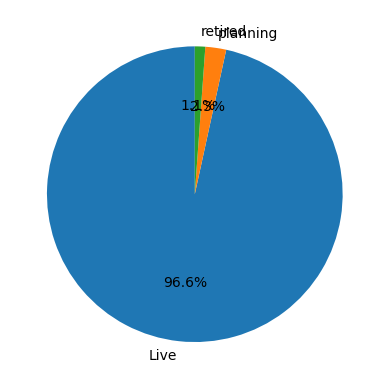

In [52]:
ask_rta_bot('Plot Pie chart of Status')